In [1]:
from basicgeo import P2, P3
from wingshape import WingShape
from parapolygraph import ParamPolyGraph
import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
print("Parametrization in uv: ", wingshape.urange, wingshape.vrange)
# approximately flat and in metres (based around section 7) without the compression at the leading edge    
#parapolygraph = ParamPolyGraph(wingshape, "segmentedwing.txt", deprecatedTrimFile=True)
#parapolygraph.saveas("test.json")
parapolygraph = ParamPolyGraph(wingshape, "test.json")


Parametrization in uv:  (0, 6.11206792886613) (-1.377293405726668, 1.377293405726668)


<IPython.core.display.Javascript object>


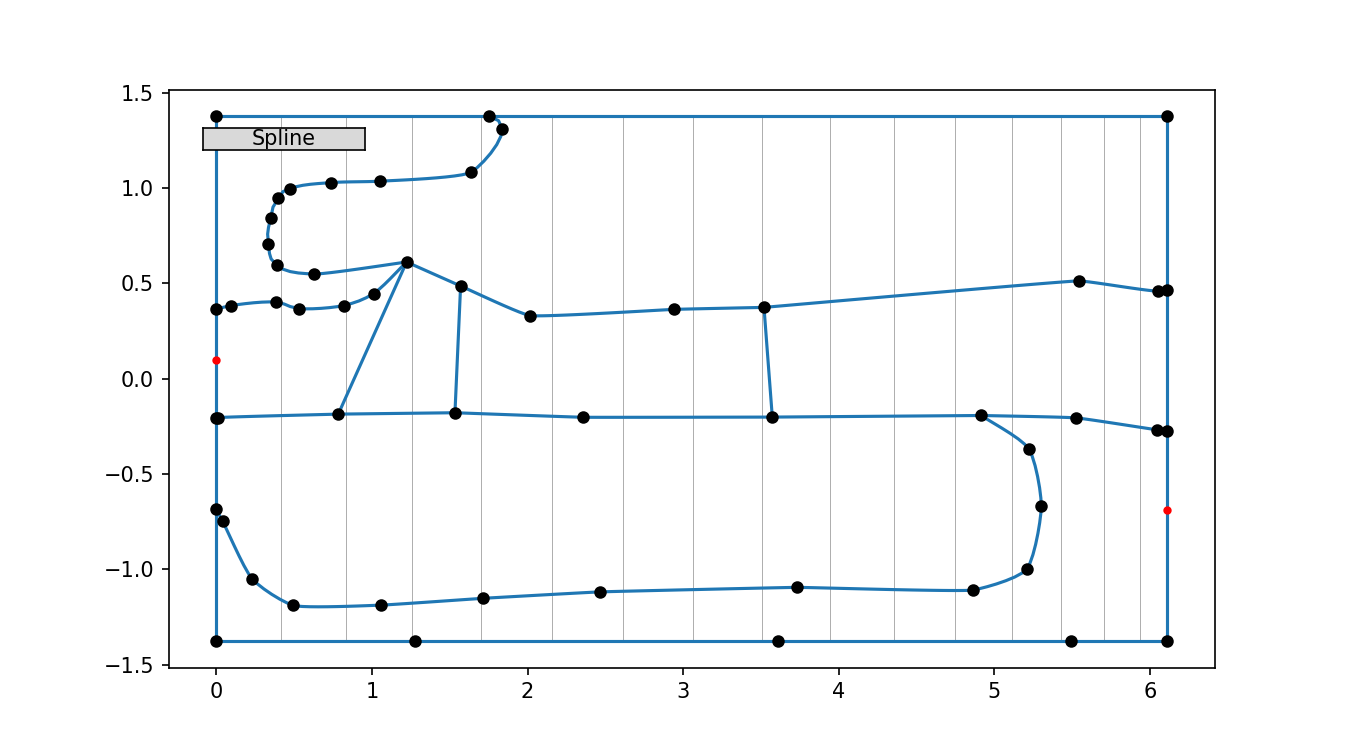

In [2]:
%matplotlib notebook

from matplotlib import pyplot as plt
import interactiveuvpara

fig = plt.figure(figsize=(9,5))
interactiveuvpara.makeinteractivefigure(fig, parapolygraph)
plt.show()

In [3]:
parapolygraph.saveas("test.json")


<IPython.core.display.Javascript object>


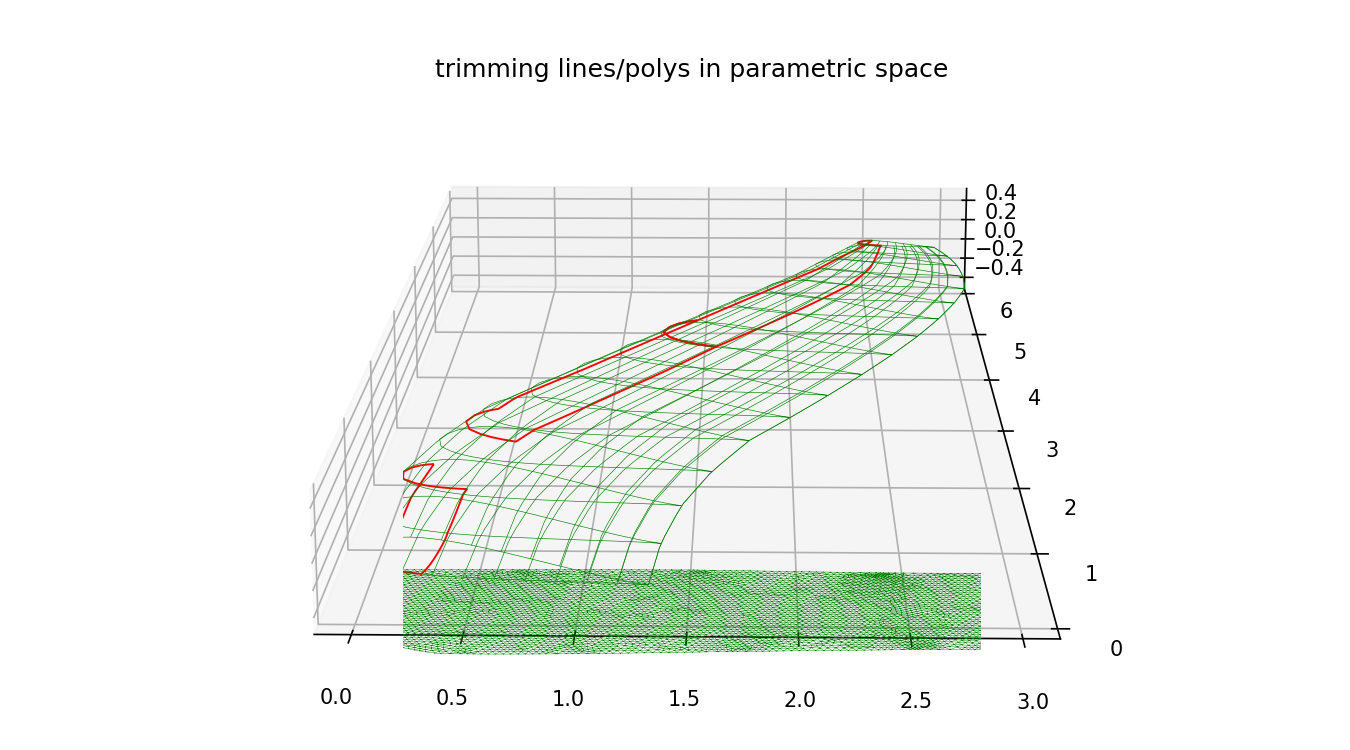

(0.0, 6.0)

In [2]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy

def flipyz(p):
    return P3(p.x, p.z, p.y)

parapolygraph.splineinterplegsdata()

fig = plt.figure(figsize=(9,5))
ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

seglines = [ [flipyz(wingshape.seval(P2(u,v)))  for v in numpy.linspace(wingshape.vrange[0], wingshape.vrange[1], 51)]  for u in wingshape.leadingedgelengths ]
spanlines = [ [flipyz(wingshape.seval(P2(u,v)))  for u in numpy.linspace(wingshape.urange[0], wingshape.urange[1], 51)]  for v in numpy.linspace(wingshape.vrange[0], wingshape.vrange[1], 21) ]
lc3d = Line3DCollection(seglines+spanlines, color="green", linewidth=0.3)
ax3d.add_collection(lc3d)

polysnodes = parapolygraph.derivepolygons()
segpolys = [ ]
for k in [0, 4, 2]:
    polyloop = parapolygraph.splinedpolypoints(polysnodes[k])
    segpolys.append([flipyz(wingshape.seval(p))  for p in polyloop])
    segpolys[-1].append(segpolys[-1][0])
lp3d = Line3DCollection(segpolys, color="red", linewidth=0.9)
ax3d.add_collection(lp3d)



ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)

/nix/store/sr711v3q725xxiybwnlfx6167s1zhqy4-python3.9-numpy-1.21.2/lib/python3.9/site-packages/numpy/ctypeslib.py:518: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return asarray(obj)


<IPython.core.display.Javascript object>


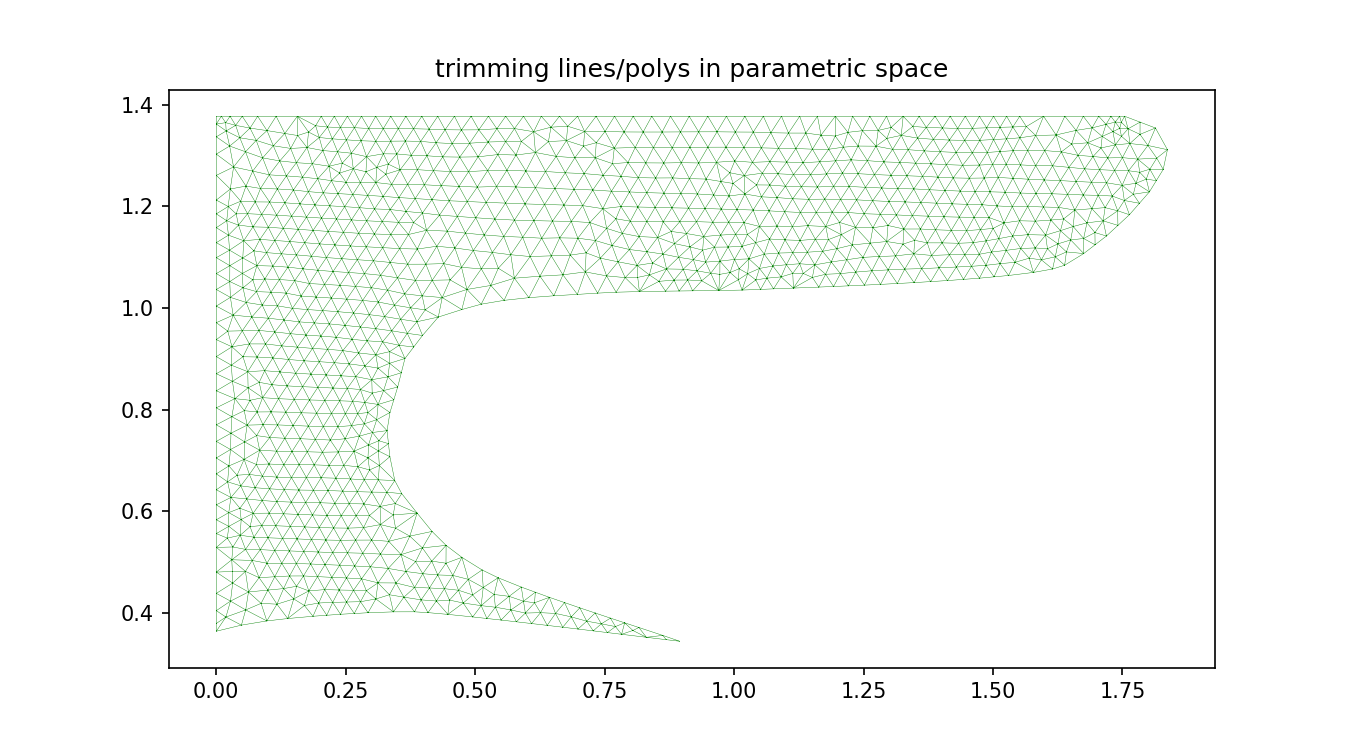

In [9]:
import pygmsh

polyloop = parapolygraph.splinedpolypoints(polysnodes[5])
with pygmsh.geo.Geometry() as g:
    g.add_polygon(polyloop, mesh_size=0.05)
    mesh = g.generate_mesh()
X = mesh.points[:,0]
Y = mesh.points[:,1]

fig = plt.figure(figsize=(9,5))
plt.triplot(X, Y, mesh.cells_dict["triangle"], color="green", linewidth=0.2)
plt.title("trimming lines/polys in parametric space");


In [5]:
X

array([3.57288237, 3.5852065 , 3.60616324, ..., 2.60949931, 3.34972891,
       0.94323509])